<a href="https://colab.research.google.com/github/danzgaming21/G1401221059_Muhammad-Abdan-Rofi/blob/main/Analisis_NBR_%26_GAM_(PP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# STEP 1 — Setup & Load
!pip -q install statsmodels patsy

import pandas as pd
import numpy as np
import re

# Jika upload manual:
from google.colab import files
uploaded = files.upload()   # lalu set FILE_PATH sesuai filename

FILE_PATH = "Negbin PP.csv"  # ganti jika nama file berbeda

# CSV kamu pakai semicolon ';'
df = pd.read_csv(FILE_PATH, sep=';')

# Normalisasi nama kolom (lowercase, strip)
df.columns = df.columns.str.strip()
print("Kolom:", list(df.columns)[:30])
df.head()


Saving Negbin PP.csv to Negbin PP (1).csv
Kolom: ['tanggal', 'waktu_posting', 'likesCount', 'views', 'commentsCount', 'type', 'hashtags', 'url']


,tanggal,waktu_posting,likesCount,views,commentsCount,type,hashtags,url
0,14/08/2025,12:04:06,213,NaN,5,Sidecar,InsanPP EmpoweringTheFuture PTPPMembangunNeger...,https://www.instagram.com/p/DNVbJg6xWka/
1,14/08/2025,02:00:00,3285,NaN,160,Sidecar,PembangunanMerata KemerdekaanSemakinNyata BUMN...,https://www.instagram.com/p/DNPMbqeS_jR/
2,13/08/2025,11:49:38,239,NaN,7,Image,DeliveringExcellence SustainingTheFuture 72Tah...,https://www.instagram.com/p/DNS0sr3RG_f/
3,13/08/2025,11:43:55,181,NaN,4,Sidecar,NaN,https://www.instagram.com/p/DNS0CyiSLVc/
4,12/08/2025,13:19:55,442,NaN,7,Sidecar,PPeduli SahabatPP! EmpoweringTheFuture PTPPMem...,https://www.instagram.com/p/DNQaPEbxN-A/


In [20]:
# ==== 2) Parse timestamp -> WIB ====
# utc=True akan menganggap nilai naive sebagai UTC dan menjadikannya tz-aware
ts_utc   = pd.to_datetime(df["waktu_posting"], errors="coerce", utc=True)
ts_wib   = ts_utc.dt.tz_convert("Asia/Jakarta")  # ganti ke "Asia/Makassar" (WITA) / "Asia/Jayapura" (WIT) kalau perlu

/tmp/ipython-input-1808684727.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts_utc   = pd.to_datetime(df["waktu_posting"], errors="coerce", utc=True)


In [21]:
# STEP 2 — Deteksi Kolom
def find_col(candidates):
    colmap = {c.lower().strip(): c for c in df.columns}
    for cand in candidates:
        key = cand.lower().strip()
        if key in colmap:
            return colmap[key]
    # fallback contains
    for c in df.columns:
        for cand in candidates:
            if cand.lower() in c.lower():
                return c
    return None

col_likes   = find_col(["likes","like","jumlah_like","likecount","like_count"])
col_comms   = find_col(["comments","comment","komentar","jumlah_komen","commentcount","comment_count"])
col_views   = find_col(["views","view","play_count","playcount","video_views","videoviewcount"])
col_type    = find_col(["content_type","post_type","jenis","format","media_type","jenis postingan"])
col_caption = find_col(["caption","deskripsi","text","keterangan"])
col_hashtag = find_col(["hashtags","hashtag","#","tags"])
col_time    = find_col(["datetime","tanggal","created_at","posted_at","time","waktu","date"])

# Pilih target (count)
target_col = col_likes or col_comms or col_views
assert target_col is not None, "Tidak menemukan kolom target likes/comments/views."

print("Target (y):", target_col)
print("Fitur kandidat:", dict(
    content_type=col_type, caption=col_caption, hashtags=col_hashtag, time=col_time, views=col_views))


Target (y): likesCount
Fitur kandidat: {'content_type': None, 'caption': None, 'hashtags': 'hashtags', 'time': 'tanggal', 'views': 'views'}


In [22]:
# STEP 3 — Feature Engineering (FIXED)
work = df.copy()

# Target
work[target_col] = pd.to_numeric(work[target_col], errors="coerce")
work = work[work[target_col].notna() & (work[target_col] >= 0)]

# =========================
# A) DATETIME (fix: dayfirst & gabung tanggal + waktu bila terpisah)
# =========================
def parse_datetime_flex(df_in, col_time, extra_time_cols=("waktu_posting", "time", "jam")):
    df_ = df_in.copy()
    dt = None

    # 1) Kalau ada kolom tanggal + kolom waktu terpisah → gabung
    date_col = col_time
    time_aux = None
    if col_time is not None and col_time in df_.columns:
        date_col = col_time
        for c in extra_time_cols:
            if c in df_.columns:
                time_aux = c
                break

    if date_col is not None and date_col in df_.columns:
        # Normalisasi tanggal (dayfirst=True sesuai warning)
        dates = pd.to_datetime(df_[date_col], errors="coerce", dayfirst=True, infer_datetime_format=True)

        if time_aux:
            # Gabungkan tanggal + waktu string jadi datetime
            times = df_[time_aux].astype(str).str.strip()
            # Jika format waktu kosong/NaN, anggap "00:00:00"
            times = times.where(times.str.len() > 0, "00:00:00")
            # Gabung
            dt = pd.to_datetime(dates.dt.date.astype(str) + " " + times, errors="coerce", dayfirst=True)
        else:
            dt = dates
    else:
        dt = pd.NaT

    return dt

work["__dt"] = parse_datetime_flex(work, col_time)

# Fallback: kalau __dt masih semuanya NaT, coba cari kolom 'tanggal' dan 'waktu_posting' eksplisit
if work["__dt"].isna().all():
    date_guess = None
    time_guess = None
    for c in work.columns:
        lc = c.lower().strip()
        if date_guess is None and ("tanggal" in lc or "date" in lc):
            date_guess = c
        if time_guess is None and ("waktu" in lc or "time" in lc or "posted" in lc):
            time_guess = c
    if date_guess is not None:
        d = pd.to_datetime(work[date_guess], errors="coerce", dayfirst=True, infer_datetime_format=True)
        if time_guess is not None:
            t = work[time_guess].astype(str).str.strip().where(lambda s: s.str.len() > 0, "00:00:00")
            work["__dt"] = pd.to_datetime(d.dt.date.astype(str) + " " + t, errors="coerce", dayfirst=True)
        else:
            work["__dt"] = d

# Turunkan jam & hari
work["hour"] = work["__dt"].dt.hour
work["dow"]  = work["__dt"].dt.dayofweek  # 0=Senin

# =========================
# B) CAPTION LENGTH
# =========================
if col_caption is not None:
    work["caption_len"] = work[col_caption].astype(str).str.len()
else:
    work["caption_len"] = 0

# =========================
# C) HASHTAG COUNT (fix: selalu Series, bukan string)
# =========================
if col_hashtag is not None:
    # Coba treat sebagai numerik (kalau sudah ada jumlah hashtag)
    htry = pd.to_numeric(work[col_hashtag], errors="coerce")
    if htry.notna().sum() > 0:
        work["hashtag_cnt"] = htry.fillna(0)
    else:
        # Hitung dari teks (pakai kolom hashtags jika string, else fallback ke caption)
        src_series = work[col_hashtag].astype(str)
        work["hashtag_cnt"] = src_series.str.count(r"#")
else:
    # Fallback hitung dari caption jika ada
    if col_caption is not None:
        work["hashtag_cnt"] = work[col_caption].astype(str).str.count(r"#")
    else:
        # Pastikan tetap Series
        work["hashtag_cnt"] = pd.Series(0, index=work.index, dtype="int64")

# =========================
# D) CONTENT TYPE (kategori)
# =========================
if col_type is not None:
    work["content_type"] = work[col_type].astype(str).str.strip().str.title()
else:
    work["content_type"] = "Unknown"

# =========================
# E) LOG(VIEWS)
# =========================
if col_views is not None:
    work["log_views"] = np.log1p(pd.to_numeric(work[col_views], errors="coerce").fillna(0))
else:
    work["log_views"] = 0.0

# =========================
# F) RINGKASAN
# =========================
y = work[target_col].astype(int)
print("N sampel:", len(work), "| y mean:", y.mean(), "| y var:", y.var())
work.head()


N sampel: 45 | y mean: 569.5555555555555 | y var: 346634.79797979794


/tmp/ipython-input-1077782823.py:27: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dates = pd.to_datetime(df_[date_col], errors="coerce", dayfirst=True, infer_datetime_format=True)
/tmp/ipython-input-1077782823.py:35: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt = pd.to_datetime(dates.dt.date.astype(str) + " " + times, errors="coerce", dayfirst=True)


,tanggal,waktu_posting,likesCount,views,commentsCount,type,hashtags,url,__dt,hour,dow,caption_len,hashtag_cnt,content_type,log_views
0,14/08/2025,12:04:06,213,NaN,5,Sidecar,InsanPP EmpoweringTheFuture PTPPMembangunNeger...,https://www.instagram.com/p/DNVbJg6xWka/,2025-08-14 12:04:06,12,3,0,0,Unknown,0.0
1,14/08/2025,02:00:00,3285,NaN,160,Sidecar,PembangunanMerata KemerdekaanSemakinNyata BUMN...,https://www.instagram.com/p/DNPMbqeS_jR/,2025-08-14 02:00:00,2,3,0,0,Unknown,0.0
2,13/08/2025,11:49:38,239,NaN,7,Image,DeliveringExcellence SustainingTheFuture 72Tah...,https://www.instagram.com/p/DNS0sr3RG_f/,2025-08-13 11:49:38,11,2,0,0,Unknown,0.0
3,13/08/2025,11:43:55,181,NaN,4,Sidecar,NaN,https://www.instagram.com/p/DNS0CyiSLVc/,2025-08-13 11:43:55,11,2,0,0,Unknown,0.0
4,12/08/2025,13:19:55,442,NaN,7,Sidecar,PPeduli SahabatPP! EmpoweringTheFuture PTPPMem...,https://www.instagram.com/p/DNQaPEbxN-A/,2025-08-12 13:19:55,13,1,0,0,Unknown,0.0


In [23]:
# STEP 4 — Overdispersion check sederhana
y_mean = y.mean()
y_var  = y.var()
ratio  = y_var / y_mean if y_mean > 0 else np.nan
print(f"Mean(y)={y_mean:.2f}  Var(y)={y_var:.2f}  Var/Mean={ratio:.2f}")
print("Jika Var/Mean >> 1, data overdispersed → NegBin cocok.")


Mean(y)=569.56  Var(y)=346634.80  Var/Mean=608.61
Jika Var/Mean >> 1, data overdispersed → NegBin cocok.


In [24]:
# STEP 5 — Siapkan formula
from patsy import dmatrices

# Fitur kandidat
features = []
if "log_views" in work:      features.append("log_views")
if "hashtag_cnt" in work:    features.append("hashtag_cnt")
if "caption_len" in work:    features.append("caption_len")
if work["hour"].notna().any(): features.append("C(hour)")
if work["dow"].notna().any():  features.append("C(dow)")
if "content_type" in work:   features.append("C(content_type)")

formula = target_col + " ~ " + " + ".join(features) if features else target_col + " ~ 1"
print("Formula:", formula)

y_mat, X_mat = dmatrices(formula, data=work, return_type="dataframe")
y_vec = y_mat.iloc[:,0]
print("X shape:", X_mat.shape, "| y shape:", y_vec.shape)


Formula: likesCount ~ log_views + hashtag_cnt + caption_len + C(hour) + C(dow) + C(content_type)
X shape: (45, 22) | y shape: (45,)


In [25]:
# STEP 6 — Poisson baseline
import statsmodels.api as sm

poisson = sm.GLM(y_vec, X_mat, family=sm.families.Poisson()).fit()
print(poisson.summary())

# Pearson chi2 / df_resid → jika >> 1, overdispersion
pearson_chi2 = ((y_vec - poisson.mu)**2 / poisson.mu).sum()
od_stat = pearson_chi2 / poisson.df_resid
print(f"Overdispersion stat (Pearson χ²/df) = {od_stat:.2f}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:             likesCount   No. Observations:                   45
Model:                            GLM   Df Residuals:                       25
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1921.7
Date:                Wed, 20 Aug 2025   Deviance:                       3490.3
Time:                        06:38:41   Pearson chi2:                 3.87e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.3428      0.061     87.098

In [26]:
# STEP 7 — NEGATIVE BINOMIAL (robust, anti-singular)

import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices

# ---------- 7A) Kurangi risiko kolinearitas ----------
# 1) Bin jam (daripada 24 dummy C(hour))
if "hour" in work.columns:
    # 4 bin default: (0-6], (6-12], (12-18], (18-24]
    work["hour_bin"] = pd.cut(work["hour"], bins=[-0.1,6,12,18,24], labels=["0-6","6-12","12-18","18-24"])
else:
    work["hour_bin"] = np.nan

# 2) Kurangi dummy hari (opsional: drop)
use_dow = False  # set True kalau mau tetap pakai hari
if not use_dow and "dow" in work.columns:
    work = work.drop(columns=["dow"])

# 3) Buang kolom varians nol (konstan)
def drop_zero_variance_cols(dfX):
    keep = []
    for c in dfX.columns:
        if dfX[c].dtype.kind in "biufc":  # numeric-like
            if dfX[c].nunique(dropna=True) > 1:
                keep.append(c)
        else:
            keep.append(c)
    return dfX[keep]

# ---------- 7B) Bangun formula yang lebih ringan ----------
features = []
if "log_views" in work:        features.append("log_views")
if "hashtag_cnt" in work:      features.append("hashtag_cnt")
if "caption_len" in work:      features.append("caption_len")
if "content_type" in work:     features.append("C(content_type)")
if "hour_bin" in work:         features.append("C(hour_bin)")

formula_nb = target_col + " ~ " + " + ".join(features) if features else target_col + " ~ 1"
print("Formula (NB):", formula_nb)

# Design matrices via patsy
y_mat, X_mat = dmatrices(formula_nb, data=work, return_type="dataframe")
y_vec = y_mat.iloc[:,0]

# Buang kolom varians nol di X (kalau ada)
X_mat = drop_zero_variance_cols(X_mat)

# Pastikan tidak ada intercept ganda
if "Intercept" not in X_mat.columns and "const" not in X_mat.columns:
    X_nb = sm.add_constant(X_mat, prepend=True)
else:
    X_nb = X_mat.copy()

# ---------- 7C) Coba fit dengan Discrete NB; kalau singular, fallback ke GLM-NB ----------
from statsmodels.discrete.discrete_model import NegativeBinomial

try:
    nb = NegativeBinomial(y_vec, X_nb).fit(maxiter=200, disp=False)
    used_glm = False
except Exception as e:
    print(f"[Discrete NB gagal: {e}] → fallback ke GLM Negative Binomial")

    # Estimasi alpha dari Poisson via Pearson chi2
    pois = sm.GLM(y_vec, X_nb, family=sm.families.Poisson()).fit()
    pearson_chi2 = ((y_vec - pois.mu)**2 / pois.mu).sum()
    alpha_est = max((pearson_chi2 - pois.df_resid) / pois.mu.sum(), 1e-8)

    nb = sm.GLM(y_vec, X_nb, family=sm.families.NegativeBinomial(alpha=alpha_est)).fit()
    used_glm = True

print(nb.summary())
print("\nModel yang dipakai:", "GLM-NB (fallback, lebih stabil)" if used_glm else "Discrete NB")

# ---------- 7D) IRR (exp(beta)) + CI ----------
import numpy as np

params = nb.params
conf   = nb.conf_int()
irr    = np.exp(params)
irr_ci = np.exp(conf)

irr_table = pd.DataFrame({
    "coef": params,
    "IRR": irr,
    "CI_lower": irr_ci[0],
    "CI_upper": irr_ci[1],
    "p_value": nb.pvalues
}).rename_axis("term").reset_index().sort_values("p_value")

irr_table


Formula (NB): likesCount ~ log_views + hashtag_cnt + caption_len + C(content_type) + C(hour_bin)
                     NegativeBinomial Regression Results                      
Dep. Variable:             likesCount   No. Observations:                   45
Model:               NegativeBinomial   Df Residuals:                       41
Method:                           MLE   Df Model:                            3
Date:                Wed, 20 Aug 2025   Pseudo R-squ.:                 0.02273
Time:                        06:38:47   Log-Likelihood:                -320.31
converged:                       True   LL-Null:                       -327.76
Covariance Type:            nonrobust   LLR p-value:                  0.001902
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    7.1510      0.293     24.425      0.000       6.577       7.725
C(ho

,term,coef,IRR,CI_lower,CI_upper,p_value
0,const,7.151027,1275.415554,718.530407,2263.905355,9.193469e-132
4,alpha,0.461702,1.586772,1.326876,1.897574,4.215327e-07
1,C(hour_bin)[T.6-12],-1.073512,0.341806,0.187928,0.621680,4.358051e-04
2,C(hour_bin)[T.12-18],-1.078500,0.340105,0.168347,0.687103,2.648129e-03
3,log_views,0.010299,1.010352,0.969564,1.052856,6.242410e-01


In [27]:
from statsmodels.discrete.discrete_model import Poisson

pois = Poisson(y_vec, X_nb).fit(maxiter=200, disp=False)
print("AIC Poisson:", pois.aic, "AIC NegBin:", nb.aic)


AIC Poisson: 13380.140858630955 AIC NegBin: 650.6256805338788


In [28]:
from statsmodels.stats.anova import anova_lm
# perbandingan Poisson vs NegBin juga bisa lewat log-likelihood ratio


In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_nb, i) for i in range(X_nb.shape[1])]
print(vif)


[np.float64(8.075145743079743), np.float64(2.000029183021675), np.float64(2.000349497762993), np.float64(1.0002358564114462)]


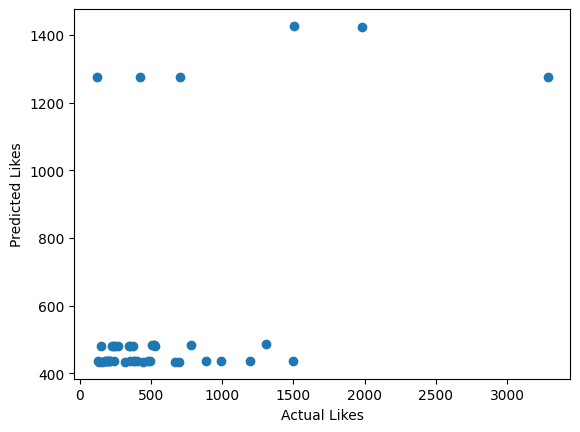

In [30]:
import matplotlib.pyplot as plt

work["pred_likes"] = nb.predict(X_nb)
plt.scatter(work["likesCount"], work["pred_likes"])
plt.xlabel("Actual Likes")
plt.ylabel("Predicted Likes")
plt.show()

In [38]:
# === 1) LOAD & FEATURE ENGINEERING ===
import pandas as pd
import numpy as np

# Baca CSV (pakai delimiter ';')
df = pd.read_csv("Negbin PP.csv", sep=";")

# Pastikan numeric
for c in ["likesCount","commentsCount","views"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Waktu → hour & day_of_week
# tanggal format dd/mm/yyyy; waktu_posting HH:MM:SS
dt = pd.to_datetime(df["tanggal"] + " " + df["waktu_posting"], errors="coerce", dayfirst=True)
df["hour"] = dt.dt.hour
df["day_of_week"] = dt.dt.dayofweek  # 0=Mon .. 6=Sun

# Fitur lain
df["log_views"]   = np.log1p(df["views"].fillna(0))
df["hashtag_cnt"] = df["hashtags"].astype(str).str.count(r"#")
df["content_type"] = df["type"].astype(str).str.title()

# Target (boleh ganti ke 'commentsCount' jika mau komentar)
TARGET = "likesCount"

# Drop baris tanpa target / tanpa jam
data = df.dropna(subset=[TARGET, "hour"]).copy()
data[TARGET] = data[TARGET].astype(int)

print("N =", len(data))
data[[ "tanggal","waktu_posting","hour","day_of_week","likesCount","views","log_views","hashtag_cnt","content_type"]].head()


N = 45


,tanggal,waktu_posting,hour,day_of_week,likesCount,views,log_views,hashtag_cnt,content_type
0,14/08/2025,12:04:06,12,3,213,NaN,0.0,0,Sidecar
1,14/08/2025,02:00:00,2,3,3285,NaN,0.0,0,Sidecar
2,13/08/2025,11:49:38,11,2,239,NaN,0.0,0,Image
3,13/08/2025,11:43:55,11,2,181,NaN,0.0,0,Sidecar
4,12/08/2025,13:19:55,13,1,442,NaN,0.0,0,Sidecar


In [39]:
# === 2) GAM components (smoother & linear) ===
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

# Smoother untuk 3 fitur numerik non-linear
smooth_cols = ["hour", "log_views", "hashtag_cnt"]
X_smooth = data[smooth_cols].to_numpy()

# Pilih jumlah knot (df) & derajat spline
bs = BSplines(
    X_smooth,
    df=[10, 8, 6],      # fleksibilitas (bisa disesuaikan)
    degree=[3, 3, 3],   # cubic splines
)

# Linear part: content_type (dummy) + intercept otomatis dari GLM
X_lin = pd.get_dummies(data["content_type"], drop_first=True)  # baseline = kategori pertama
y = data[TARGET].to_numpy()

print("Linear columns:", list(X_lin.columns))


Linear columns: ['Sidecar', 'Video']


In [40]:
# === 3) Grid-search alpha untuk Negative Binomial ===
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

alphas = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0]
best = {"alpha": None, "aic": np.inf, "res": None}

for a in alphas:
    fam = sm.families.NegativeBinomial(alpha=a)
    try:
        res = GLMGam(y, exog=X_lin, smoother=bs, family=fam).fit()
        aic = res.aic if hasattr(res, "aic") else np.nan
        print(f"alpha={a:<4}  AIC={aic:.3f}")
        if aic < best["aic"]:
            best = {"alpha": a, "aic": aic, "res": res}
    except Exception as e:
        print(f"alpha={a} gagal: {e}")

nb_gam = best["res"]
print("\n>> Alpha terbaik:", best["alpha"], "| AIC:", round(best["aic"], 3))
print(nb_gam.summary())


alpha=0.05  AIC=809.052
alpha=0.1   AIC=699.026
alpha=0.2   AIC=657.799
alpha=0.5   AIC=656.556
alpha=1.0   AIC=676.286
alpha=2.0   AIC=706.446

>> Alpha terbaik: 0.5 | AIC: 656.556
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   45
Model:                         GLMGam   Df Residuals:                    29.72
Model Family:        NegativeBinomial   Df Model:                        14.28
Link Function:                    Log   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -313.00
Date:                Wed, 20 Aug 2025   Deviance:                       29.861
Time:                        07:59:19   Pearson chi2:                     27.4
No. Iterations:                    28   Pseudo R-squ. (CS):             0.4947
Covariance Type:            nonrobust                                         
                 coef    std

In [41]:
# === 4) Prediksi & metrik ringkas ===
mu = nb_gam.predict()  # mean prediksi
y_true = y.astype(float)

MAE  = np.mean(np.abs(y_true - mu))
RMSE = np.sqrt(np.mean((y_true - mu)**2))
print(f"MAE={MAE:.2f}  RMSE={RMSE:.2f}")

# (Opsional) pseudo-R2 McFadden sederhana vs intercept-only
# Fit intercept-only (linear kosong, tetap gunakan smoother kosong)
# Kita aproksimasi dengan GLM NB intercept-only:
X0 = np.ones((len(y_true), 1))
res0 = sm.GLM(y_true, X0, family=sm.families.NegativeBinomial(alpha=best["alpha"])).fit()
pseudo_r2 = 1 - (nb_gam.llf / res0.llf)
print(f"McFadden pseudo-R² ≈ {pseudo_r2:.4f}")


MAE=250.28  RMSE=442.28
McFadden pseudo-R² ≈ 0.0468


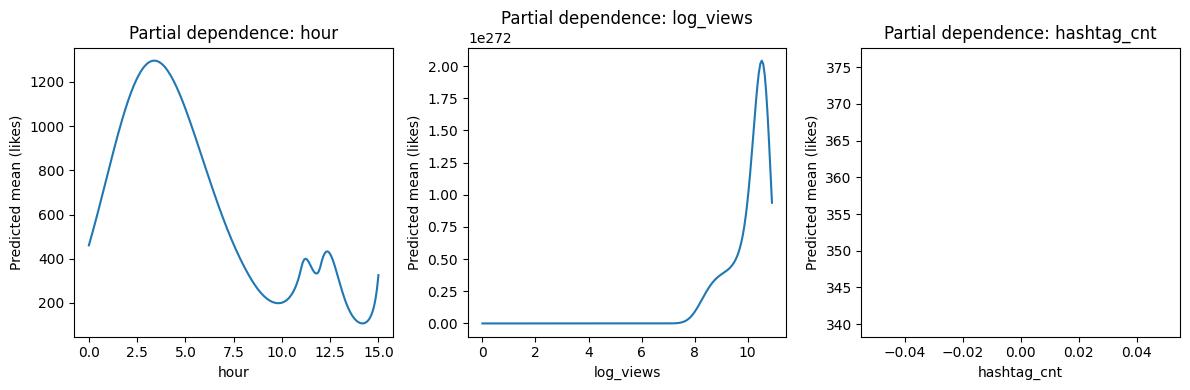

In [43]:
# === 5) Partial dependence untuk fitur smooth (FIXED) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# simpan nama kolom linear (dummy) agar mudah dipakai di fungsi
X_LIN_COLS = list(X_lin.columns)
SMOOTH_COLS = smooth_cols  # ["hour","log_views","hashtag_cnt"]

def partial_dependence_1d(model, data_df, smooth_col, n=120, grid=None):
    """
    Evaluasi efek 1 fitur smooth dengan menahan fitur smooth lain di median.
    Linear dummies diset 0 (baseline).
    """
    # 1) grid untuk kolom yang diinspeksi
    if grid is None:
        lo = float(data_df[smooth_col].min())
        hi = float(data_df[smooth_col].max())
        grid = np.linspace(lo, hi, n)

    # 2) bangun matriks smooth: baris = n, kolom = SMOOTH_COLS
    med = data_df[SMOOTH_COLS].median()
    base_smooth = pd.DataFrame(
        np.tile(med.values, (len(grid), 1)),
        columns=SMOOTH_COLS
    )
    base_smooth[smooth_col] = grid  # ganti 1 kolom dengan grid

    # 3) linear part = nol semua (baseline), ukuran baris = n
    Xlin = pd.DataFrame(0, index=range(len(grid)), columns=X_LIN_COLS)

    # 4) prediksi mean
    mu = model.predict(exog=Xlin, exog_smooth=base_smooth.values)
    return grid, mu

# --- Plot 3 partial dependence ---
plt.figure(figsize=(12,4))
for i, col in enumerate(SMOOTH_COLS, 1):
    gx, gmu = partial_dependence_1d(nb_gam, data, col, n=200)
    plt.subplot(1,3,i)
    plt.plot(gx, gmu)
    plt.title(f"Partial dependence: {col}")
    plt.xlabel(col)
    plt.ylabel("Predicted mean (likes)")
plt.tight_layout()
plt.show()


In [44]:
# === 6) Prime time dari kurva hour ===
gx, gmu = partial_dependence_1d(nb_gam, data, "hour", n=240)
peak_idx = np.argmax(gmu)
print(f"Jam Waktu Terbaik (perkiraan): {gx[peak_idx]:.2f} WIB  |  Mean likes prediksi: {gmu[peak_idx]:.1f}")


Jam Waktu Terbaik (perkiraan): 3.39 WIB  |  Mean likes prediksi: 1295.7
